## Introduction

We will create a super resolution model from scratch to enhance the image quality

## Notes:

We adjusted the paths and some liberaries to work with both jupyter and google collab (the commented code)

You must change all image and save directories to your local path

Some featues are temporary disabled in GPU training in Epoch section due to high VRAM Usage > (24GB VRAM)! (you can adjust and modify them at your discretion )

### Bugs:

Checkpoint is not saved 

High noise with low batches and step size

## Setting up Environment

### Upgrade Libraries

In [1]:
!pip install opencv-contrib-python --upgrade

In [2]:
import cv2
cv2.__version__

'4.11.0'

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid


### Mount Gdrive and download datasets / Import Dataset for jupyter

* Upload the new dataset to drive


In [4]:
dir_dataset = r'C:\Users\zeyad\Downloads\fruit\training' # change to your path

files_img = [os.path.join(dir_dataset, x) for x in os.listdir(dir_dataset)]

In [5]:
len(files_img), files_img[0: 92219]

(24,
 ['C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple 6',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Braeburn 1',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Crimson Snow 1',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Golden 1',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Golden 2',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Golden 3',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Granny Smith 1',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple hit 1',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Pink Lady 1',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Red 1',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Red 2',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Red 3',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Red Delicious 1',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Red Yellow 1',
  'C:\\Users\\zeyad\\Downloads\\fruit\\training\\Apple Red Yel

Displaying the first image: C:\Users\zeyad\Downloads\fruit\training\Apple 6\r0_0_100.jpg


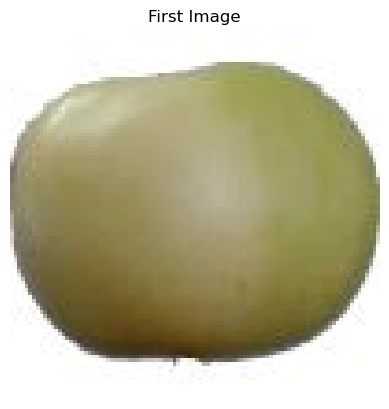

In [6]:
folder_path = r'C:\Users\zeyad\Downloads\fruit\training\Apple 6'  # Local path

# Get a list of image files
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

# Display the first image
if image_files:
    first_image_path = image_files[0]
    img = cv2.imread(first_image_path, cv2.IMREAD_UNCHANGED)
    if img is not None:
        print(f"Displaying the first image: {first_image_path}")
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title("First Image")
        plt.axis('off')
        plt.show()
    else:
        print(f"Could not load the image: {first_image_path}")
else:
    print("No image files found in the folder.")



### Downsample images

> Here we are going to write some downsampling code through which we are going to generate some low resolution images

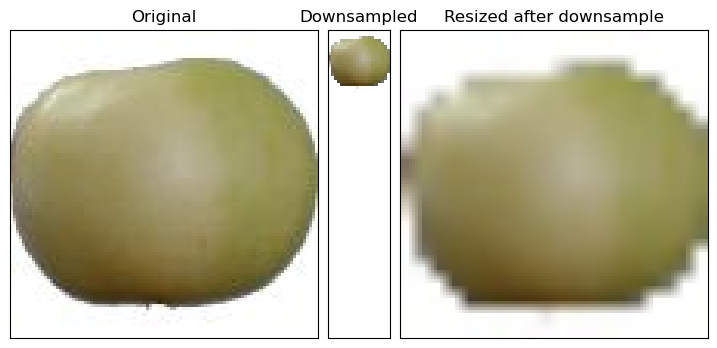

In [7]:
def plot_images(images, titles, figsize, rows=1, cols=1, axes_pad=(0.1, 0.5)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=axes_pad)

    for ax, img, title in zip(grid, images, titles):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

def downsample(img_file, scale=0.3):
    img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)

    if img is None:
        print(f"Error: Could not load image at path: {img_file}")
        return None, None

    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    img_small = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    return img, img_small

# ✅ Use raw string for local path to avoid escape issues
folder_path = r'C:\Users\zeyad\Downloads\fruit\training\Apple 6'

image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

# Display first image for testing
for image_file in image_files[:1]:
    img, img_small = downsample(image_file, scale=0.2)
    if img is not None and img_small is not None:
        resized_img = cv2.resize(img_small, (img.shape[1], img.shape[0]))
        plot_images([img, img_small, resized_img],
                    ['Original', 'Downsampled', 'Resized after downsample'],
                    figsize=(10, 4), cols=3)
    else:
        print(f"Skipping due to image load error: {image_file}")


### Lets downsample all images for training

In [8]:
def plot_images(images, titles, figsize, rows=1, cols=1, axes_pad=(0.1, 0.5)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=axes_pad)

    for ax, img, title in zip(grid, images, titles):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')
    plt.show()

def downsample(img_file, scale=0.3):
    img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)

    if img is None:
        print(f"Error: Could not load image at path: {img_file}")
        return None, None

    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    img_small = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    return img, img_small

# ✅ Local paths (use raw string or double backslashes to avoid escape issues)
input_folder_path = r'C:\Users\zeyad\Downloads\fruit\training\Apple 6'
output_folder_path = r'C:\Users\zeyad\Downloads\fruit\training\apple_lr_train'

# Create output folder if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)

# Get list of image files
image_files = [os.path.join(input_folder_path, file)
               for file in os.listdir(input_folder_path)
               if os.path.isfile(os.path.join(input_folder_path, file))]

# Process and save
for image_file in image_files:
    img, img_small = downsample(image_file, scale=0.2)  # control downsampling scale

    if img is not None and img_small is not None:
        filename = os.path.basename(image_file)
        output_path = os.path.join(output_folder_path, filename)
        cv2.imwrite(output_path, img_small)
        print(f"✅ Saved downsampled image to {output_path}")

        # Optional visualization (uncomment to show results)
        # resized_img = cv2.resize(img_small, (img.shape[1], img.shape[0]))
        # plot_images([img, img_small, resized_img], ['Original', 'Downsampled', 'Resized back'], figsize=(10, 4), cols=3)

    else:
        print(f"❌ Skipping due to image loading error: {image_file}")



✅ Saved downsampled image to C:\Users\zeyad\Downloads\fruit\training\apple_lr_train\r0_0_100.jpg
✅ Saved downsampled image to C:\Users\zeyad\Downloads\fruit\training\apple_lr_train\r0_112_100.jpg
✅ Saved downsampled image to C:\Users\zeyad\Downloads\fruit\training\apple_lr_train\r0_129_100.jpg
✅ Saved downsampled image to C:\Users\zeyad\Downloads\fruit\training\apple_lr_train\r0_156_100.jpg
✅ Saved downsampled image to C:\Users\zeyad\Downloads\fruit\training\apple_lr_train\r0_157_100.jpg
✅ Saved downsampled image to C:\Users\zeyad\Downloads\fruit\training\apple_lr_train\r0_158_100.jpg
✅ Saved downsampled image to C:\Users\zeyad\Downloads\fruit\training\apple_lr_train\r0_160_100.jpg
✅ Saved downsampled image to C:\Users\zeyad\Downloads\fruit\training\apple_lr_train\r0_161_100.jpg
✅ Saved downsampled image to C:\Users\zeyad\Downloads\fruit\training\apple_lr_train\r0_172_100.jpg
✅ Saved downsampled image to C:\Users\zeyad\Downloads\fruit\training\apple_lr_train\r0_1_100.jpg
✅ Saved downsa

## Print no of HL (Original) and LR (Downsampled Images)

In [9]:
dir_dataset_lr =  [os.path.join(output_folder_path, file) for file in os.listdir(output_folder_path) if os.path.isfile(os.path.join(output_folder_path, file))]
files_img_hr = [os.path.join(input_folder_path, file) for file in os.listdir(input_folder_path) if os.path.isfile(os.path.join(input_folder_path, file))]
print("HR images: {}, LR images: {}".format(len(files_img_hr), len(dir_dataset_lr)))

HR images: 200, LR images: 200


## Super Resolution - Model Creation

### SR GAN

In [10]:
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add, BatchNormalization, Activation, LeakyReLU, Layer
from tensorflow.keras.models import Model

In [11]:
class SubpixelConv2D(Layer):

    def __init__(self, upsampling_factor=2, **kwargs): #  refers to the instance of the class that is being operated on.
        super(SubpixelConv2D, self).__init__(**kwargs) #init the parent class and allows you to call methods of a parent class.
        self.upsampling_factor = upsampling_factor

    def build(self, input_shape):
        last_dim = input_shape[-1]
        factor = self.upsampling_factor * self.upsampling_factor
        if last_dim % (factor) != 0:
            raise ValueError('Channel ' + str(last_dim) + ' should be of integer times of upsampling_factor^2: ' +
                             str(factor) + '.')

    def call(self, inputs, **kwargs):
        return tf.nn.depth_to_space(inputs, self.upsampling_factor) # convert input from (h, w, c) to (h*r, w*r, c/(r*r)),

    def get_config(self):   # returns a dictionary that contains the configuration of the layer
        config = {'upsampling_factor': self.upsampling_factor}
        base_config = super(SubpixelConv2D, self).get_config()  #super() is a built-in function that allows you to call a method in a parent class(Layer).
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        factor = self.upsampling_factor * self.upsampling_factor

        input_shape_1 = None
        if input_shape[1] is not None:
            input_shape_1 = input_shape[1] * self.upsampling_factor

        input_shape_2 = None
        if input_shape[2] is not None:
            input_shape_2 = input_shape[2] * self.upsampling_factor

        dims = [ input_shape[0],   #batch size
                 input_shape_1,  # h
                 input_shape_2,  # w
                 int(input_shape[3]/factor)  #channel/factor
               ]
        return tuple( dims )

In [12]:
from tensorflow.keras.layers import Dense

# create a Dense layer with some configuration
dense_layer = Dense(units=64, activation='relu')

# get the configuration of the layer
config = dense_layer.get_config()
print(config)
# recreate the layer from the configuration
new_dense_layer = Dense.from_config(config)
# check that the two layers are equivalent
print(dense_layer.get_config() == new_dense_layer.get_config()) # should print True

{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
True


In [13]:
config = {'upsampling_factor': 2}
base_config = {'config': 4}
print(dict(list(base_config.items()) + list(config.items())))

{'config': 4, 'upsampling_factor': 2}


In [14]:
# Assuming you have this class SubpixelConv2D defined or imported
class SubpixelConv2D(tf.keras.layers.Layer):
    def __init__(self, upsampling_factor=2, **kwargs):
        super(SubpixelConv2D, self).__init__(**kwargs)
        self.upsampling_factor = upsampling_factor

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.upsampling_factor)

    def get_config(self):
        config = super(SubpixelConv2D, self).get_config()
        config['upsampling_factor'] = self.upsampling_factor
        return config

# GPU memory growth (optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Define input
input_shape = (4, 4, 16)
upsampling_factor = 2

input_tensor = Input(shape=input_shape)
x = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(input_tensor)
output_tensor = SubpixelConv2D(upsampling_factor=upsampling_factor)(x)

# Build model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Output shape
print(model.output_shape)


(None, 8, 8, 16)


### Generator

In [15]:
def generator_model(input_shape):
    # w_init = tf.random_normal_initializer(stddev=0.02)

    g_init = tf.random_normal_initializer(1., 0.02)
    relu = Activation('relu')

    layer_input = Input(shape=input_shape)
    # input shape 64 x 64 for generator
    #conv2d kernal size in  the paper (9,9)
    #activation function in the paper Prelu in the code we using relu
    # kernel_initializer='HeNormal   for initi  weight for conv2d  ( --- read about it ---)
    layer_past_block = Conv2D(64, (3,3), padding='SAME', activation= 'relu', kernel_initializer='HeNormal')(layer_input)
    # layer_initial = layer_past_block to save first layer information for sum at the end of residual blocks
    layer_initial = layer_past_block

    # B residual blocks
    for i in range(16):
        # in the paper they use  16 residual blocks
        layer = Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer_past_block)
        layer = BatchNormalization(gamma_initializer=g_init)(layer)

        layer = add([layer_past_block, layer])
        layer_past_block = layer

    layer = Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer_past_block)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)
    layer = add([layer, layer_initial])  # adding initial layer, such that model can skip entire residual blocks
    # B residual blocks end

    #layer = layer_initial # extra

    layer = Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = SubpixelConv2D(upsampling_factor=2)(layer)
    layer = relu(layer)

    layer = Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = SubpixelConv2D(upsampling_factor=2)(layer)
    layer = relu(layer)

    #layer_final = Conv2D(3, (1,1), padding='SAME', kernel_initializer='HeNormal', activation= 'tanh')(layer)
    #kernal conv2d final layer kernal size 9x9 in the paper
    layer_final = Conv2D(3, (1,1), padding='SAME', kernel_initializer='HeNormal', activation= 'relu')(layer)

    model = Model(inputs=layer_input, outputs=layer_final, name="generator")
    return model

### Discriminator

In [16]:
# discriminator
def discriminator_model(input_shape):

    g_init= tf.random_normal_initializer(1., 0.02)

    ly_relu= LeakyReLU(alpha= 0.2)

    df_dim = 16

    layer_input = Input(input_shape)

    layer = Conv2D(64, (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(layer_input)
    layer = ly_relu(layer)

    for i in range(2, 6):
        layer = Conv2D(df_dim*(2**i), (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(layer)
        layer = ly_relu(layer)
        layer = BatchNormalization(gamma_initializer=g_init)(layer)

    layer = Conv2D(df_dim*16, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = ly_relu(layer)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)

    layer = Conv2D(df_dim*8, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)
    layer_past = layer

    # Residual Block starts
    layer = Conv2D(df_dim*4, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = ly_relu(layer)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)

    layer = Conv2D(df_dim*8, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = BatchNormalization(gamma_initializer= g_init)(layer)

    layer = add([layer, layer_past])
    # Residual Block ends

    layer = Flatten()(layer)
    layer_final = Dense(units=1, kernel_initializer='HeNormal', activation= 'sigmoid')(layer)
    model = Model(inputs=layer_input, outputs=layer_final, name="discriminator")

    return model

In [17]:
for i in range(2, 6):
  print(i)
  print("======")
  print(16*(2**i))

2
64
3
128
4
256
5
512


### VGG model

In [18]:
def vgg19_model(input_shape):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    # Create a model from input to layer 17 (layer index 0-16 included)
    model = Model(inputs=vgg.input, outputs=vgg.layers[16].output, name='vgg')
    return model

### Hyperparams

In [19]:
# learning_rate = 0.0002

# ## Adversarial learning (SRGAN)
# n_epoch = 10       ## overall training epochs
# n_epoch_init = 5  ## initialize generator with Epochs
# batch_size = 16    ## batch size for training
# steps_per_epoch = 500

# # create folders to save result images and trained models
# img_save_dir = "samples"
# checkpoint_dir = "models"


## low GPU memory test
learning_rate = 0.0002

## Adversarial learning (SRGAN)
n_epoch = 10         # total training epochs
n_epoch_init = 5     # epochs to pretrain generator
batch_size = 4       # lowered for low GPU (was 16)
steps_per_epoch = 50  # optional: reduce steps if running out of time or memory

# create folders to save result images and trained models
img_save_dir = "samples"
checkpoint_dir = "models"


#### Ensuring directories exist

In [20]:
if os.path.exists(img_save_dir):
    shutil.rmtree(img_save_dir)

os.makedirs(img_save_dir)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

### Datasets Iterator

In [21]:
# Set paths to the folders containing sub folder with images
dir_dataset_lr = os.path.join(output_folder_path, 'sub_dir')
dir_dataset_hr = os.path.join(input_folder_path, 'sub_dir')

batch_size = 32

# Dataset from folders
dataset_lr = tf.keras.utils.image_dataset_from_directory(
    output_folder_path,  # not the class_a folder, just the root
    labels=None,
    image_size=(64, 64),
    batch_size=batch_size,
    shuffle=False
)

dataset_hr = tf.keras.utils.image_dataset_from_directory(
    input_folder_path,
    labels=None,
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=False
)

# Zip LR and HR
dataset = tf.data.Dataset.zip((dataset_lr, dataset_hr))


Found 200 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


HR shape: (256, 256, 3), LR shape: (64, 64, 3)


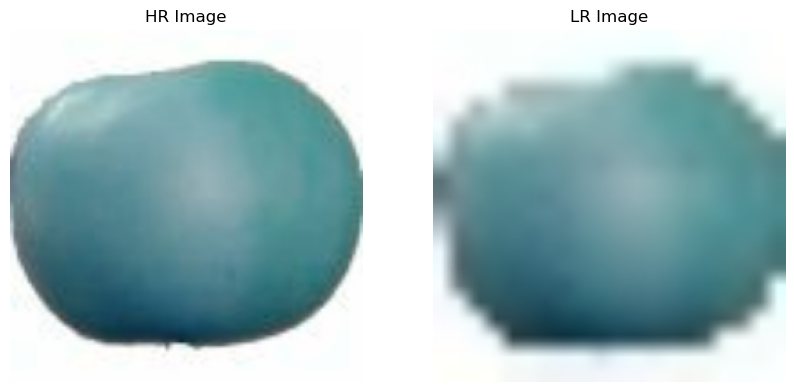

HR shape: (256, 256, 3), LR shape: (64, 64, 3)


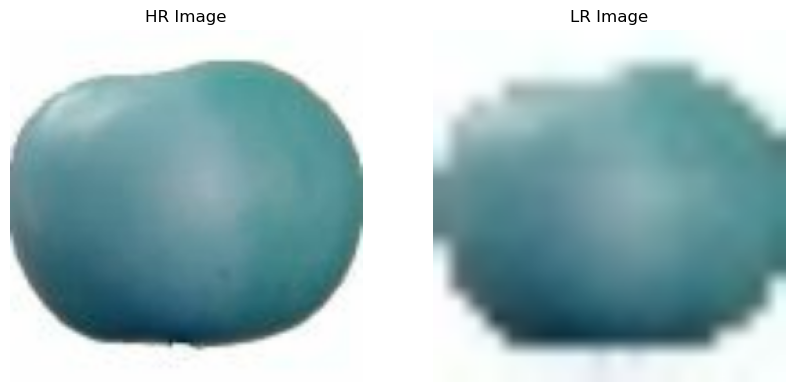

HR shape: (256, 256, 3), LR shape: (64, 64, 3)


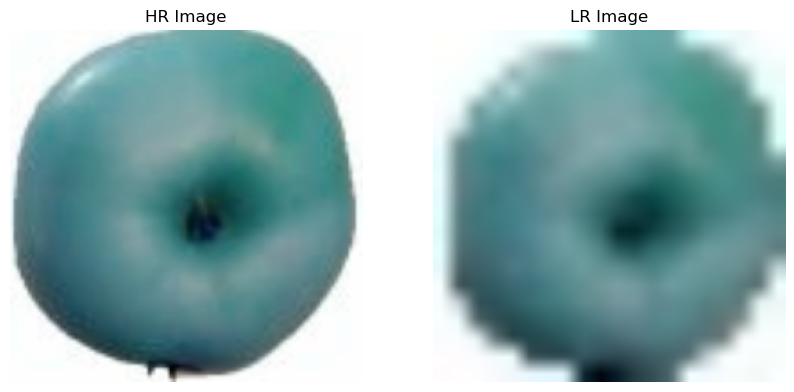

HR shape: (256, 256, 3), LR shape: (64, 64, 3)


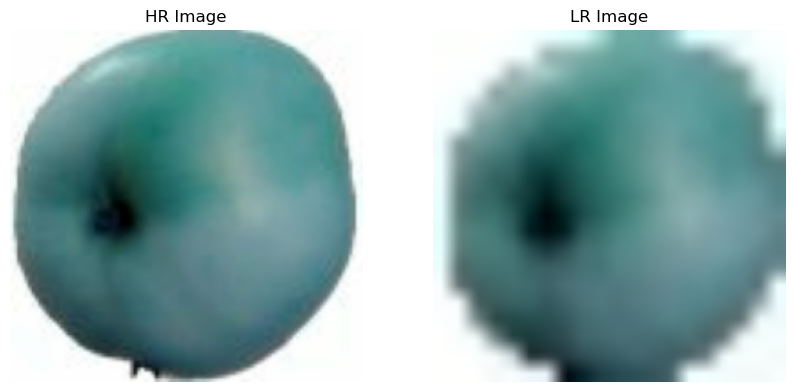

HR shape: (256, 256, 3), LR shape: (64, 64, 3)


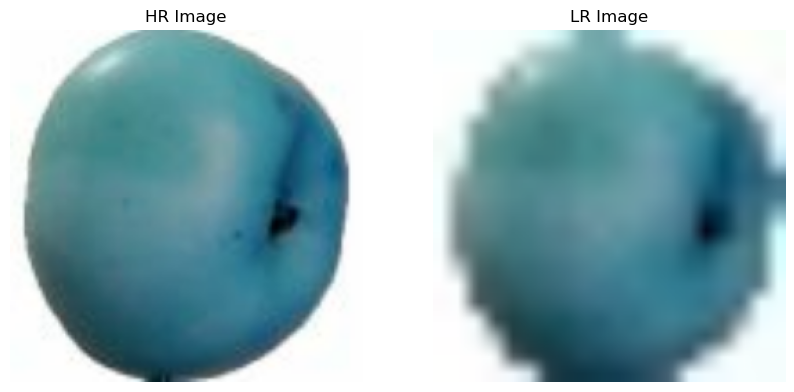

HR shape: (256, 256, 3), LR shape: (64, 64, 3)


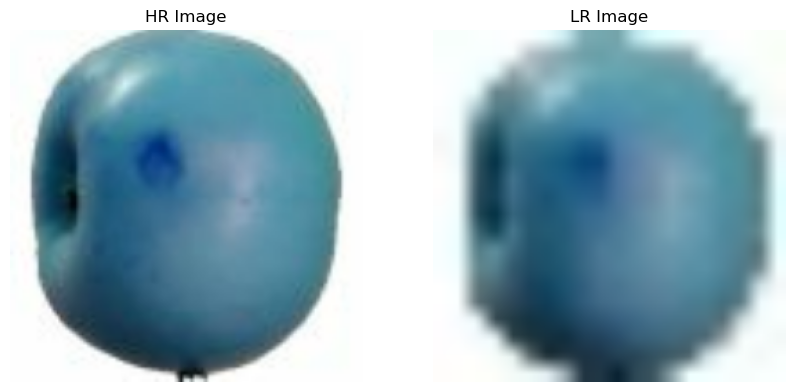

HR shape: (256, 256, 3), LR shape: (64, 64, 3)


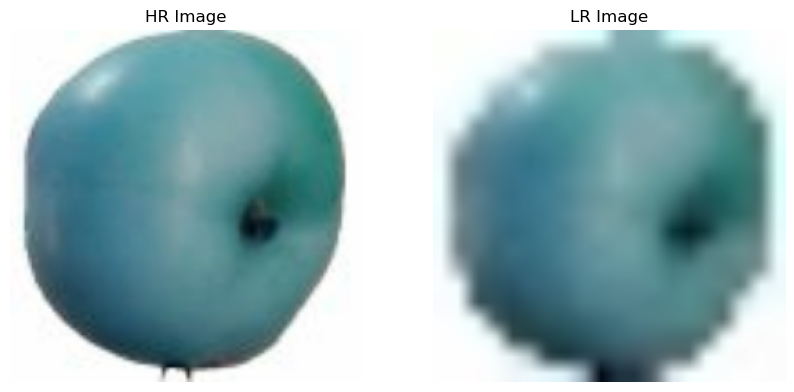

In [22]:
# Assuming dataset is a batch of images (like from a tf.data.Dataset)
i = 0
for img_batch_lr, img_batch_hr in dataset:  # Assuming you have the dataset loaded

    # Convert to numpy array if using TensorFlow
    img_hr = img_batch_hr[0].numpy()
    img_lr = img_batch_lr[0].numpy()

    # Print image shapes for debugging
    print(f"HR shape: {img_hr.shape}, LR shape: {img_lr.shape}")

    # Ensure the images have values in the expected range (0-255 for uint8 images)
    if img_lr.dtype != np.uint8:
        img_lr = np.clip(img_lr, 0, 255).astype(np.uint8)
    if img_hr.dtype != np.uint8:
        img_hr = np.clip(img_hr, 0, 255).astype(np.uint8)

    # Resize LR image to match HR size
    img_lr_resize = cv2.resize(img_lr, (img_hr.shape[1], img_hr.shape[0]))

    # Ensure images are in the correct format for matplotlib (RGB)
    img_lr_resize_rgb = cv2.cvtColor(img_lr_resize, cv2.COLOR_BGR2RGB)
    img_hr_rgb = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)

    # Display the images side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].imshow(img_hr_rgb)
    ax[0].set_title("HR Image")
    ax[0].axis('off')

    ax[1].imshow(img_lr_resize_rgb)
    ax[1].set_title("LR Image")
    ax[1].axis('off')

    plt.show()

    if i > 6:
        break

    i += 1



### Initialization

In [23]:
model_gen = generator_model((64, 64, 3))
model_dis = discriminator_model((256, 256, 3))
model_vgg = vgg19_model((256, 256, 3))

In [24]:
g_optimizer_init = tf.optimizers.Adam(learning_rate)
g_optimizer = tf.optimizers.Adam(learning_rate)
d_optimizer = tf.optimizers.Adam(learning_rate)

### Initialize Generator

Lets give generator head start by letting it train alone for some steps

In [25]:
from PIL import Image

g_optimizer_init = tf.optimizers.Adam(0.0002)

# Lets run generator for initial epochs
for epoch in range(n_epoch_init):
    for step, (X, Y) in enumerate(dataset):

        if step > steps_per_epoch:
            break

        with tf.GradientTape() as tape:
            Y_pred = model_gen(X)

            # Our loss function is MSE of pixel differences in actual and generated image
            mse_loss = tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(Y, Y_pred), axis=-1))
            grad = tape.gradient(mse_loss, model_gen.trainable_weights)
            g_optimizer_init.apply_gradients(zip(grad, model_gen.trainable_weights))

        if step % 100 == 0:
            print("Epoch: [{}/{}] step, mse: {:.3f} ".format(epoch, step , mse_loss))

        if step == 0:
            img = model_gen.predict(X[0:1])[0]
            #img = Image.fromarray(np.uint8(img * 255))
            img = Image.fromarray(np.uint8(img))
            img.save(os.path.join(img_save_dir, '{}_g_init.png'.format(epoch)))

Epoch: [0/0] step, mse: 990292934656.000 
Epoch: [1/0] step, mse: 9888047104.000 
Epoch: [2/0] step, mse: 1038911296.000 
Epoch: [3/0] step, mse: 142839184.000 
Epoch: [4/0] step, mse: 54612528.000 


Found 5 images.
Loaded 5 images.


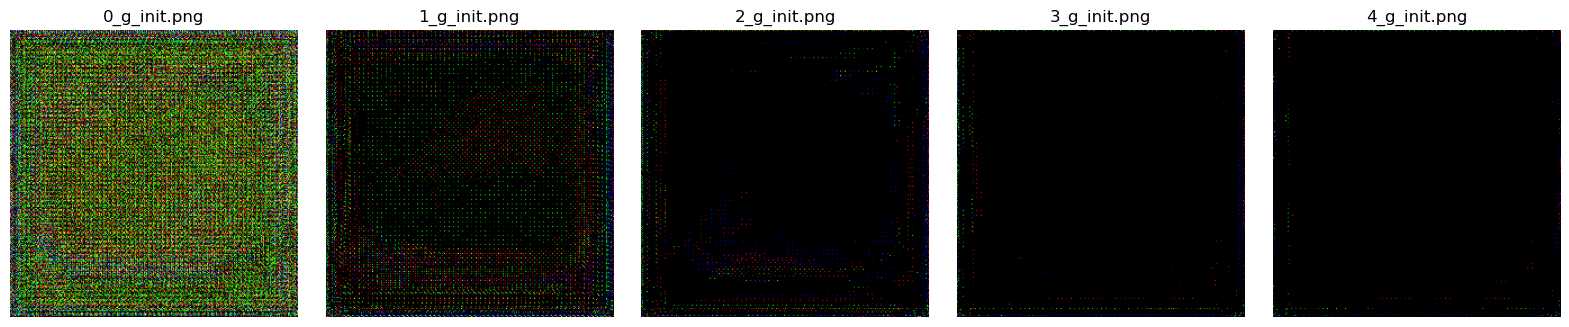

In [26]:
# Function to plot images
def plot_images(images, titles, figsize, rows=1, cols=1, axes_pad=(0.1, 0.5)):
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(rows, cols, figure=fig, wspace=axes_pad[0], hspace=axes_pad[1])

    for i, (img, title) in enumerate(zip(images, titles)):
        ax = fig.add_subplot(grid[i])
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')

    plt.show()

# Directory to check
img_save_dir = r'C:\Users\zeyad\samples'  ######### please change to your path #########

# Get all file paths
sample_images_filepaths = [os.path.join(img_save_dir, x) for x in os.listdir(img_save_dir)]
sample_images_filepaths = list(filter(lambda x: not 'train' in x, sample_images_filepaths))

# Check if there are images to process
if not sample_images_filepaths:
    print("No images found in the directory.")
else:
    print(f"Found {len(sample_images_filepaths)} images.")

# Sort the paths (based on the first element before '_')
sample_images_filepaths.sort(key=lambda x: x.split('_')[0])

# Load images and titles
images = [cv2.imread(x) for x in sample_images_filepaths]
titles = [os.path.basename(x) for x in sample_images_filepaths]

# Ensure all images are loaded
if not all(img is not None for img in images):
    print("Some images could not be loaded. Please check the file paths.")
else:
    print(f"Loaded {len(images)} images.")

# Plot if images exist
if images:
    plot_images(images, titles, figsize=(20., 8.), rows=1, cols=len(images))
else:
    print("No images to display.")


In [27]:
# for epoch in range(n_epoch):
#     for step, (X, Y) in enumerate(dataset):

#         if step > steps_per_epoch:
#             break

#         with tf.GradientTape(persistent=True) as tape:
#             fake_img = model_gen(X)
#             fake_logits = model_dis(fake_img)
#             real_logits = model_dis(Y)
#             fake_feature = model_vgg(fake_img)
#             real_feature = model_vgg(Y)

#             # Discriminator. loss
#             d_loss1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.zeros_like(fake_logits)))
#             d_loss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(real_logits, tf.ones_like(real_logits)))
#             d_loss = d_loss1 + d_loss2

#             # Generator. loss
#             g_gan_loss = 2e-3 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.ones_like(fake_logits)))
#             mse_loss   = 2e-1 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))
#             vgg_loss   = 2e-6 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_feature, real_feature), axis=-1)) #is used to calculate the mean value of the VGG loss across the batch.
#             g_loss = mse_loss + vgg_loss + g_gan_loss

#             grad = tape.gradient(g_loss, model_gen.trainable_weights)
#             g_optimizer.apply_gradients(zip(grad, model_gen.trainable_weights))

#             grad = tape.gradient(d_loss, model_dis.trainable_weights)
#             d_optimizer.apply_gradients(zip(grad, model_dis.trainable_weights))

#         if step % 100 == 0:
#             print("Epoch: [{}/{}] step: D.loss: {:.3f}: G.loss: {:.3f}".format(epoch, step , d_loss, g_loss))

#         if step == 0:
#             img = model_gen.predict(X[0:1])[0]
#             img = Image.fromarray(np.uint8(img))
#             img.save(os.path.join(img_save_dir, '{}_g_train.png'.format(epoch)))

##### fix high vram usage 

for epoch in range(n_epoch):
    for step, (X, Y) in enumerate(dataset):
        
        if step > steps_per_epoch:
            break

        with tf.GradientTape(persistent=True) as tape:
            fake_img = model_gen(X)
            # Only calculate generator loss, skip discriminator loss for now
            fake_logits = model_dis(fake_img)
            real_logits = model_dis(Y)
            
            # Disable feature extraction to save VRAM
            # fake_feature = model_vgg(fake_img)
            # real_feature = model_vgg(Y)

            # Discriminator loss (commented out for VRAM savings)
            d_loss1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.zeros_like(fake_logits)))
            d_loss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(real_logits, tf.ones_like(real_logits)))
            d_loss = d_loss1 + d_loss2

            # Generator loss
            g_gan_loss = 2e-3 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.ones_like(fake_logits)))
            mse_loss = 2e-1 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))
            # VGG loss (commented out for VRAM savings)
            # vgg_loss = 2e-6 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_feature, real_feature), axis=-1))
            g_loss = mse_loss + g_gan_loss  # Just use MSE and GAN loss for testing
            
            # Gradients calculation
            grad = tape.gradient(g_loss, model_gen.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, model_gen.trainable_weights))

            # Discriminator gradients (optional for testing)
            # grad = tape.gradient(d_loss, model_dis.trainable_weights)
            # d_optimizer.apply_gradients(zip(grad, model_dis.trainable_weights))

        if step % 100 == 0:
            print("Epoch: [{}/{}] step: D.loss: {:.3f}: G.loss: {:.3f}".format(epoch, step, d_loss, g_loss))

        # Remove image saving for now to avoid VRAM usage
        if step == 0:
            img = model_gen.predict(X[0:1])[0]
            img = Image.fromarray(np.uint8(img))
            img.save(os.path.join(img_save_dir, '{}_g_train.png'.format(epoch)))


Epoch: [0/0] step: D.loss: 1.006: G.loss: 6039394.000
Epoch: [1/0] step: D.loss: 1.006: G.loss: 6280.337
Epoch: [2/0] step: D.loss: 1.006: G.loss: 6280.337
Epoch: [3/0] step: D.loss: 1.006: G.loss: 6280.337
Epoch: [4/0] step: D.loss: 1.006: G.loss: 6280.337
Epoch: [5/0] step: D.loss: 1.006: G.loss: 6280.337
Epoch: [6/0] step: D.loss: 1.006: G.loss: 6280.337
Epoch: [7/0] step: D.loss: 1.006: G.loss: 6280.337
Epoch: [8/0] step: D.loss: 1.006: G.loss: 6280.337
Epoch: [9/0] step: D.loss: 1.006: G.loss: 6280.337


In [28]:
# Define two tensors representing images (or data) with shape (2, 2, 3)
fake_img = tf.constant([[[1, 6, 3], [4, 5, 6]],
                        [[7, 8, 9], [10, 11, 12]]])

Y = tf.constant([[[2, 3, 4], [5, 6, 7]],
                 [[8, 9, 10], [11, 12, 13]]])

# Print the shape of the target tensor Y (should be (2, 2, 3))
print(Y.shape)

# Print a separator for readability
print("====================")

# Compute the element-wise squared difference between fake_img and Y
# This will give a tensor of the same shape (2, 2, 3) where each element is the square of the difference
# between the corresponding values in fake_img and Y
print(tf.math.squared_difference(fake_img, Y))

# Print a separator for readability
print("====================")

# Compute the mean squared difference along the last axis (axis=-1) which represents the color channels
# This reduces the shape from (2, 2, 3) to (2, 2) by averaging the squared differences across the 3 channels
print(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))

# Calculate the Mean Squared Error (MSE) loss by averaging the values computed in the previous step
# This reduces the shape from (2, 2) to a single scalar value (overall average squared error)
mse_loss = tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))

# Print the final MSE loss value
mse_loss


(2, 2, 3)
tf.Tensor(
[[[1 9 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]]], shape=(2, 2, 3), dtype=int32)
tf.Tensor(
[[3 1]
 [1 1]], shape=(2, 2), dtype=int32)


<tf.Tensor: shape=(), dtype=int32, numpy=1>

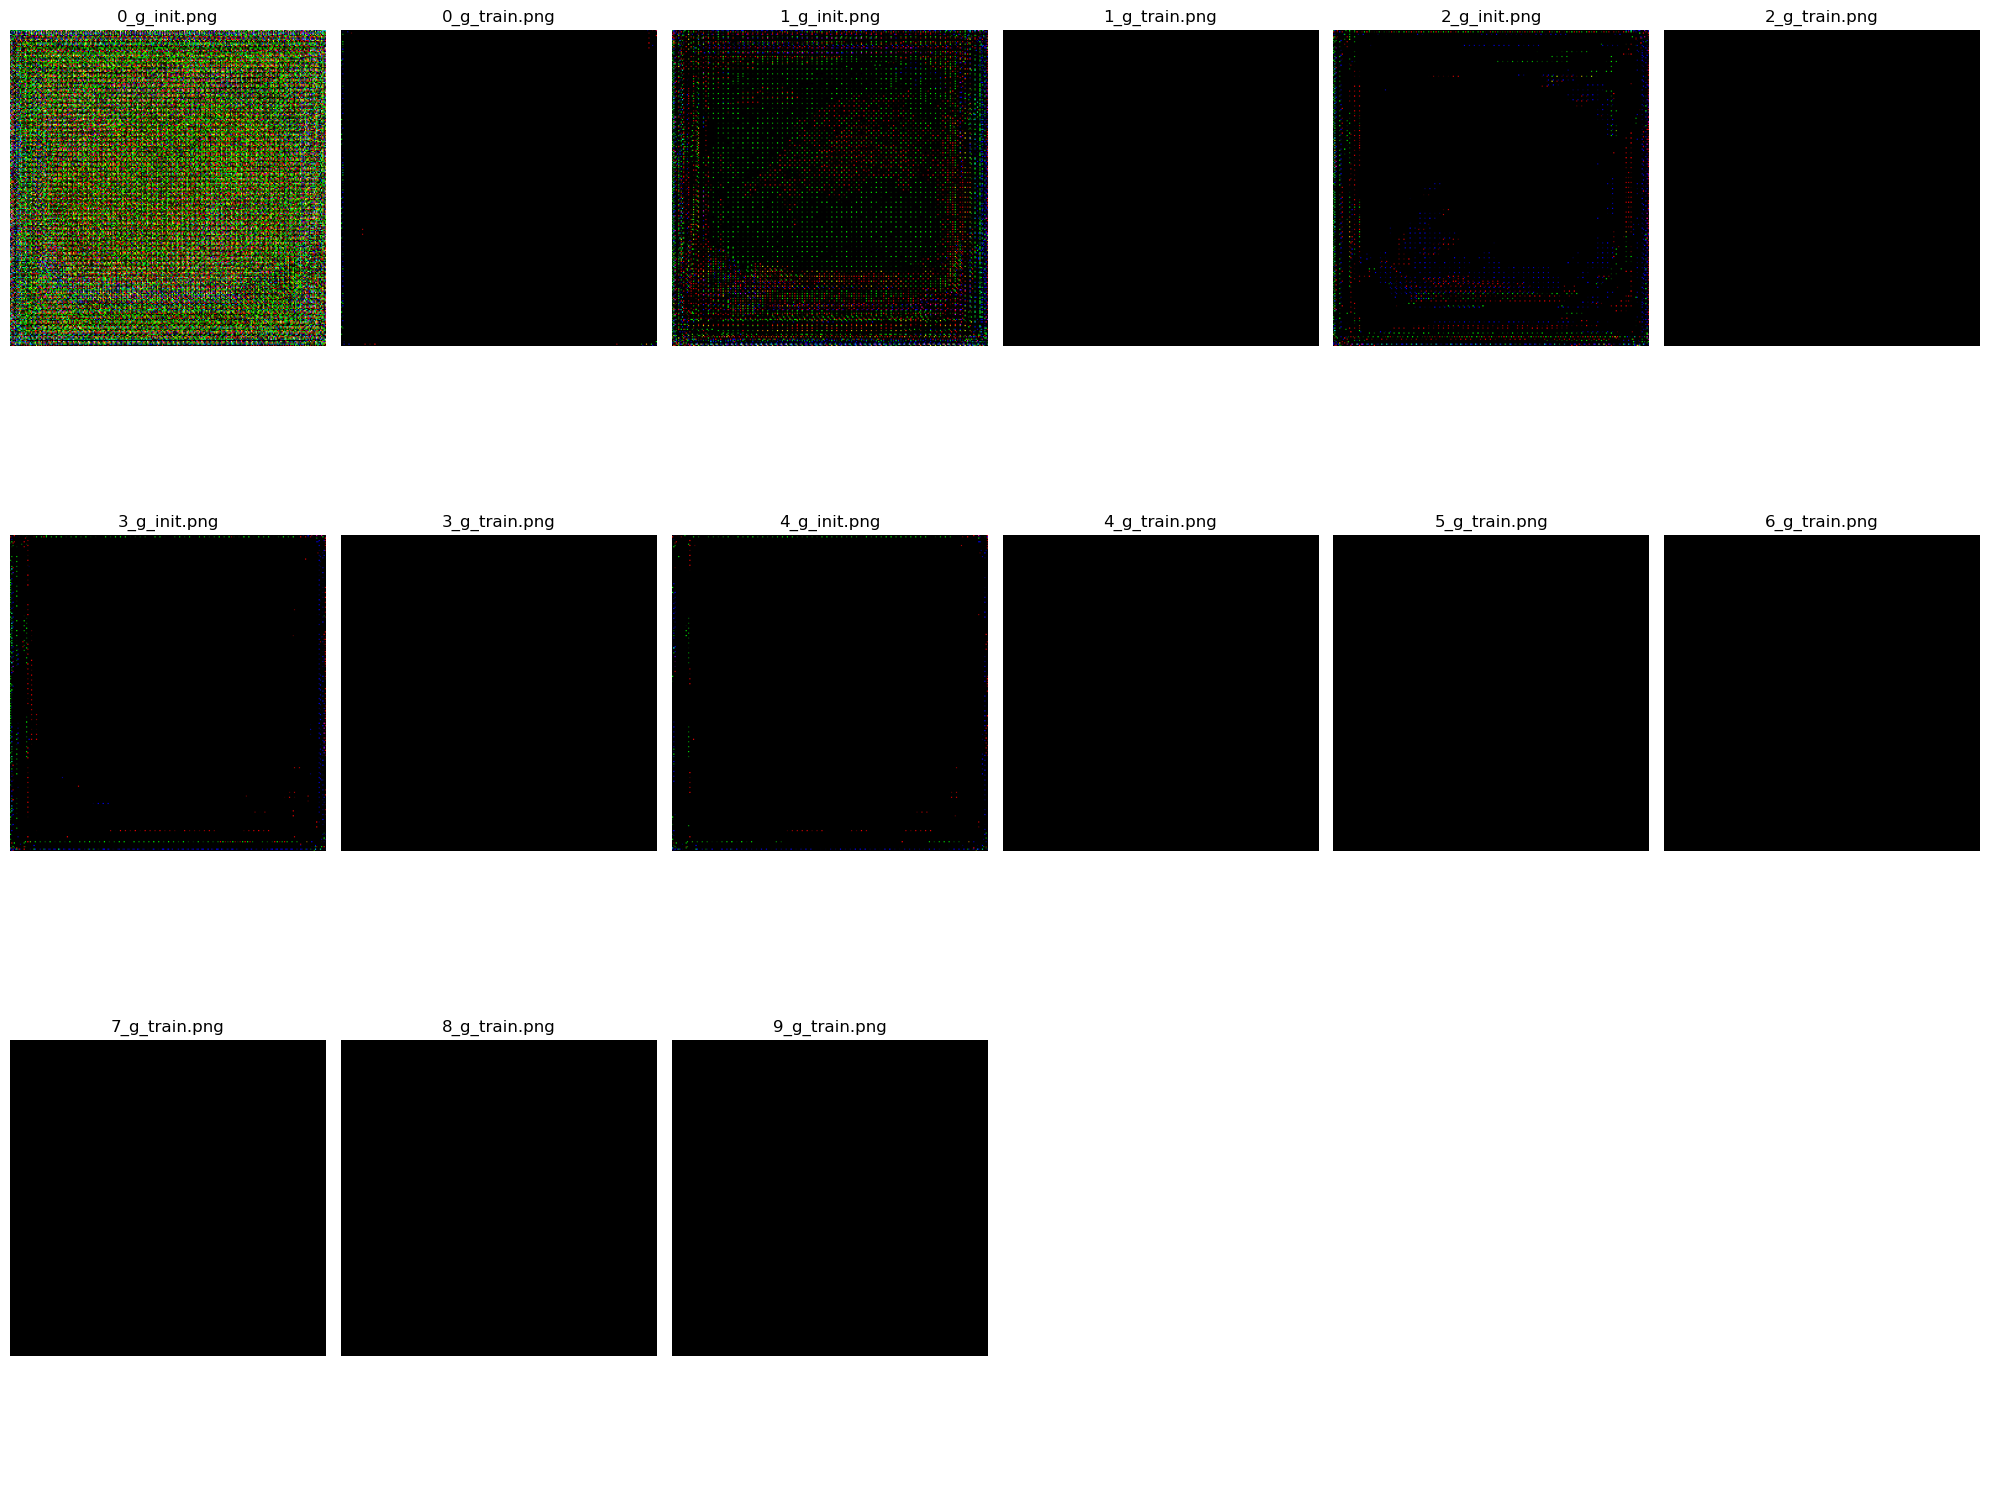

In [29]:
# Directory containing images
img_save_dir = r'C:\Users\zeyad\samples'  ######### Change to your path #########

# Get list of image file paths in the folder
sample_images_filepaths = [os.path.join(img_save_dir, x) for x in os.listdir(img_save_dir) if x.endswith(('.jpg', '.png', '.jpeg'))]

# Sort the images based on their filenames
# This handles both numeric and non-numeric filenames
def safe_sort_key(x):
    # Try to extract an integer from the filename, default to 0 if it fails
    try:
        return int(x.split('_')[0])  # Extract the first part and try to convert it to an integer
    except ValueError:
        return float('inf')  # If it fails, return a large number to sort these files last

# Sort file paths safely based on the extracted integers
sample_images_filepaths.sort(key=safe_sort_key)

# Read images into a list
images = [cv2.imread(x) for x in sample_images_filepaths]

# Convert BGR to RGB for proper display in matplotlib
images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

# Get the titles for each image (you can modify this based on your file naming convention)
titles = [os.path.basename(x) for x in sample_images_filepaths]

# Set up a grid for displaying images
n_images = len(images_rgb)
cols = 6  # You can change this to whatever fits your display
rows = (n_images // cols) + (n_images % cols > 0)  # Calculate rows based on number of images

# Create subplots to display images in a grid
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Display images in the grid
for i, (img, title) in enumerate(zip(images_rgb, titles)):
    axes[i].imshow(img)
    axes[i].set_title(title)
    axes[i].axis('off')

# Hide unused axes if there are any
for i in range(n_images, len(axes)):
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


## References

> https://learnopencv.com/super-resolution-in-opencv/<br>
> https://www.kaggle.com/code/akhileshdkapse/sr-super-resolution-gan-keras
